In [464]:
import pandas as pd
import sqlalchemy as sql
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

In [465]:
# OPTION TICKER NOT INDEX TICKER. SPXW for instance.
symbol = "SPXW"

In [466]:
engine = sql.create_engine("postgresql://postgres@localhost/optiondata")
data = pd.read_sql("SELECT * FROM horizontal_skew WHERE symbol='{0}'".format(symbol), engine)

In [467]:
dte_array = data['dte'].as_matrix()
vol_array = data['vol_factor'].as_matrix()
# Function that calculates residuals. Model is a + bt + c * sqrt(t) where t is dte and y is vol_factor
def fun(x, t, y):
    return (x[0] + (x[1] * t) + (x[2] * np.sqrt(t))) - y
# Starting guess of coeffcients. Just 1
start = np.ones(3)
# Adjusts loss function scale depending on symbol
if symbol == "RUTW":
    results = least_squares(fun, start, loss="soft_l1", f_scale=0.2, args=(dte_array, vol_array))
elif symbol == "SPXW":
    results = least_squares(fun, start, loss="soft_l1", f_scale=1, args=(dte_array, vol_array))
elif symbol == "NDX":
    results = least_squares(fun, start, loss="soft_l1", f_scale=0.15, args=(dte_array, vol_array))

In [468]:
# Calculating fitted curve
dte_range = np.arange(350)
# Results.x is fitted coeffcients
function = fun(results.x, dte_range, 0)

In [469]:
# Gets most recent date in horizontal skew and gets data for that date
recent_date = pd.read_sql("SELECT DISTINCT date FROM horizontal_skew ORDER BY date DESC LIMIT 1", engine).loc[0].date
recent_date = recent_date.isoformat()

recent_data = pd.read_sql("SELECT * FROM horizontal_skew WHERE date='{0}' AND symbol='{1}'".format(recent_date, symbol), engine)

In [470]:
recent_date

'2017-08-08'

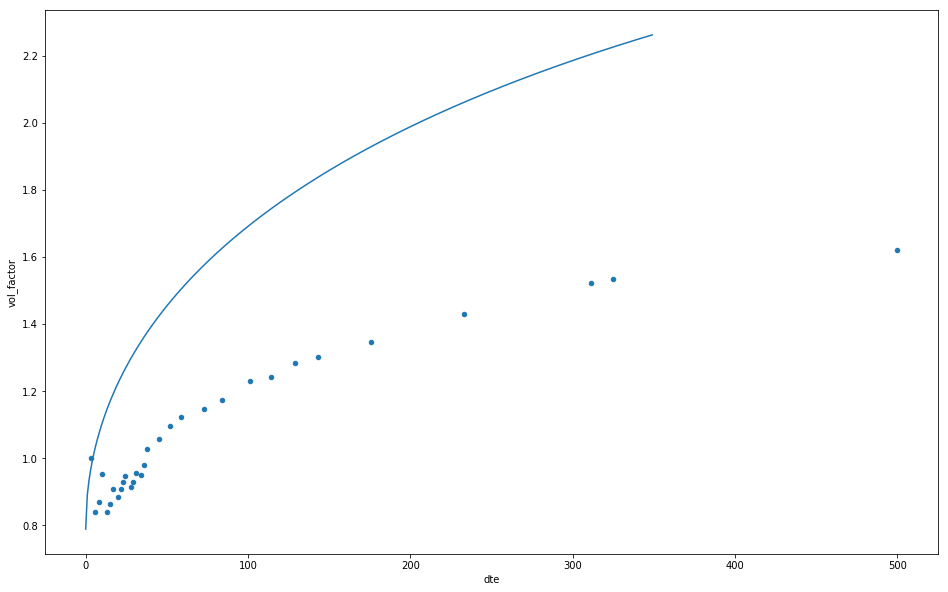

In [471]:
# Compares recent data to fitted curve
recent_data.plot(x="dte", y="vol_factor", kind="scatter")
plt.plot(function)

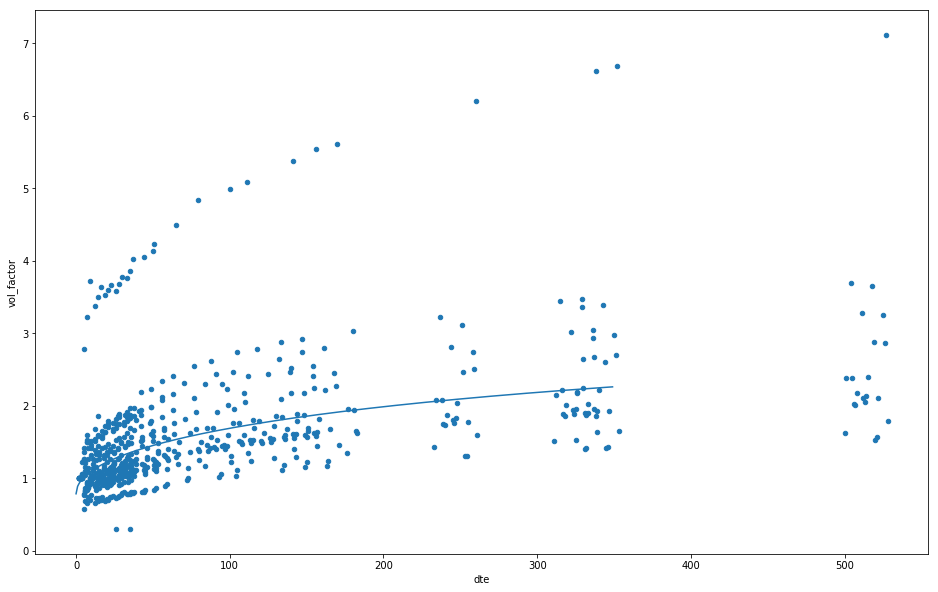

In [472]:
data.plot(x="dte", y="vol_factor", kind="scatter")
# Also plots fitted curve from regression below
plt.plot(function)